# Factor Model as Objective

In this notebook, we explore how to formulate a portfolio optimization problem where the risk estimator is not given explicitly but is instead represented by a factor model, as is common in US equity models [1].

In [1]:
# Install dependencies
%pip install numpy scipy gurobipy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Hidden cell to avoid licensing messages
# when docs are generated.
with gp.Model():
    pass

Set parameter WLSAccessID


Set parameter WLSSecret


Set parameter LicenseID to value 2443533


WLS license 2443533 - registered to Gurobi GmbH


## Background

The *standard mean-variance (Markowitz) portfolio selection model* determines optimal investments that balance risk and expected return. In this notebook, we maximize *utility*, which is defined as a weighted linear function of return and risk that can be adjusted by varying the risk-aversion coefficient $\gamma$.

The standard formulation of this problem on $n$ assets reads

\begin{alignat*}{2}
\tag{1}
\max_{x \in \mathbf{R}^{n}} \quad        & \mu^\top x - \tfrac12 \gamma\ x^\top\Sigma x \\
\mbox{s.t.} \quad & 1_n^\top x = 1 \\
& 0 \le x \le 1\\
\end{alignat*}

where $\mu \in \mathbf{R}^n$ is the return estimator, $\Sigma \in \mathbf{R}^{n,n}$ is used as an estimator for the variance, and $1_n$ is the vector of $n$ ones. While it is certainly possible that the matrix $\Sigma$ is given explicitly (e.g., as the covariance matrix of a time series), it is often expressed implicitly through a *factor model*.  In that case, the matrix $\Sigma$ takes the form

$$
\Sigma = X \Sigma_0 X^T + D
$$

where

- $X \in \mathbf{R}^{n,k}$ is the factor exposure matrix,
- $\Sigma_0 \in \mathbf{R}^{k,k}$ is the symmetric positive definite (SPD) factor covariance matrix, and
- $D \in \mathbf{R}^{n,n}$ is the *diagonal* matrix of specific risks with $d_{ii} > 0$ for all $i$.

Effectively, this splits the risk into two sources:  One that arises from common risk factors (macroeconomic conditions, market trends, etc.) and a specific risk that is uncorrelated among the assets.  The number of factors, $k$, is typically much smaller than the number $n$ of assets.

The important observation from a computational point of view is the following: The factor model data is of size $nk + n$ (with $k \ll n$), while the covariance matrix $\Sigma$ is on the order of $n^2$. As we will see, optimization models using the factor model admit a smaller representation and typically offer improved computational performance.

## A synthetic factor model

Leading industry factor models are commercial products that are not necessary for our demonstration purposes. We are more interested in a qualitative comparison of solver performance using *some* factor model than in the actual economic meaning.  For this reason, our first step will be to create a simple, synthetic multivariate factor model that we can use in the study that follows.

The following function uses an uncorrelated factor covariance matrix $\Sigma_0$ that is used for sampling a multivariate normal distribution on `num_factors` factors along `time_steps` sampling points for `num_assets` assets:

In [4]:
def factor_model(num_assets, num_factors, timesteps):
    # Generate random factor model, risk is X * sigma0 * X.T + cov(u)
    sigma0 = np.diag(1 + np.arange(num_factors) + np.random.rand(num_factors))
    X = np.random.normal(size=(num_assets, num_factors))
    alpha = np.random.normal(loc=1, size=(num_assets, 1))
    u = np.random.multivariate_normal(
        np.zeros(num_assets), np.eye(num_assets), timesteps
    ).T
    d = np.diag(np.cov(u))  # NOTE: This is the _diagonal_ of D!

    # Time series in factor space
    TS_factor = np.random.multivariate_normal(
        np.zeros(num_factors), sigma0, timesteps
    ).T

    # Estimate mu from time series in full space
    mu = np.mean(alpha + X @ TS_factor + u, axis=1)

    return X, sigma0, d, mu

We skip the details of this statistical procedure for constructing $X$, $\Sigma_0$, $D$, and $\mu$; more background and details can be found in [2, Sect. 6.6].  The essential point is that we now have a synthetic factor model that acts similarly to a commercial factor model regarding solver performance.

## Taking advantage of the factor model structure

Ignoring the constant factor $\frac{1}{2}\gamma$ for a moment, the objective function we want to maximize includes

$$
x^T \Sigma x = x^T (X \Sigma_0 X + D) x = x^T X \Sigma_0 X^T x + x^T D x
$$

The first term, $x^T X \Sigma_0 X^T x$, would result in a quadratic function having $(n+1)\frac n2$ terms.  Since $\Sigma_0$ is SPD, it admits a *Cholesky factorization* $\Sigma_0 = LL^T$ where $L \in \mathbf{R}^{k,k}$ is a triangular matrix.  This allows us to rewrite the first term as

$$
x^T X \Sigma_0 X^T x = x^T \underbrace{X L}_{B} \underbrace{L^T X^T}_{B^T} x = \underbrace{x^T B}_{y^T} \underbrace{B^T x}_{y} = y^T y
$$

where we have substituted $y = B^T x$ in the last step. Also, note that $B = X L \in \mathbf{R}^{n, k}$ comprises only $nk$ elements.

The second term, $x^T D x$, comprises only $n$ terms (i.e., $\sum_i d_{ii} x_{i}^2$) and can be used as is.  Putting this together, the standard optimization model (1) can be rewritten as

\begin{alignat}{2}
\tag{2}
\max_{x \in \mathbf{R}^{n}, y \in \mathbf{R}^k} \quad        & \mu^\top x - \tfrac12 \gamma\ y^T y + \tfrac12 \gamma\ \sum_{i=1}^n d_{ii} x_i^2\\
\mbox{s.t.} \quad & 1_n^\top x = 1 \\
& y = B^T x.\\
& 0 \le x \le 1
\end{alignat}

Note that the $k$ variables $y$ do not have bound constraints.  Model (2) contains the much smaller matrix $B$ instead of $\Sigma$ in model (1), at the expense of $k$ additional optimization variables.  Generally, form (2) is advantageous for solver performance; we shall compare both in the next step.

## Comparing the two optimization models

In order to compare the solution times for models (1) and (2) above, we will define two auxiliary functions to build an optimization model in either form.  Let's start with a function for the traditional form (1):

In [5]:
def build_sigma_model(model, gamma, sigma, mu):
    x = model.addMVar(mu.shape, lb=0.0, ub=1.0)
    model.addConstr(x.sum() == 1)
    model.setObjective(x @ mu - x @ (gamma / 2.0 * sigma) @ x, gp.GRB.MAXIMIZE)

The second function build the equivalent model (2):

In [6]:
def build_factor_model(model, gamma, B, d, mu):
    x = model.addMVar(B.shape[0], lb=0.0, ub=1.0)  # n variables
    y = model.addMVar(B.shape[1], lb=-float("inf"), ub=float("inf"))  # k variables
    model.addConstr(x.sum() == 1)
    model.addConstr(B.T @ x - y == 0)

    model.setObjective(
        x @ mu - gamma / 2.0 * y @ y - ((gamma / 2.0 * d) * x**2).sum(),
        gp.GRB.MAXIMIZE,
    )

We are now ready to run a small benchmark.  We will keep a fixed risk aversion coefficient $\gamma$, and solve both models over a range of data with an increasing number of assets:

In [7]:
np.random.seed(0xACAC)  # Fix seed for reproducibility

num_factors = 72  # USE4 has 72 factors, too (see [1])
timesteps = 700
gamma = 0.025

problem_dims = np.linspace(100, 750, 16, endpoint=True, dtype=int)
time_sigma = []
time_factor = []

for num_assets in problem_dims:
    X, sigma0, d, mu = factor_model(num_assets, num_factors, timesteps)

    with gp.Model() as m:
        m.Params.OutputFlag = 0
        sigma = X @ sigma0 @ X.T + np.diag(d)
        build_sigma_model(m, gamma, sigma, mu)
        m.optimize()
        time_sigma.append(m.RunTime)

    with gp.Model() as m:
        m.Params.OutputFlag = 0
        L = np.linalg.cholesky(sigma0)
        B = X @ L
        build_factor_model(m, gamma, B, d, mu)
        m.optimize()
        time_factor.append(m.RunTime)

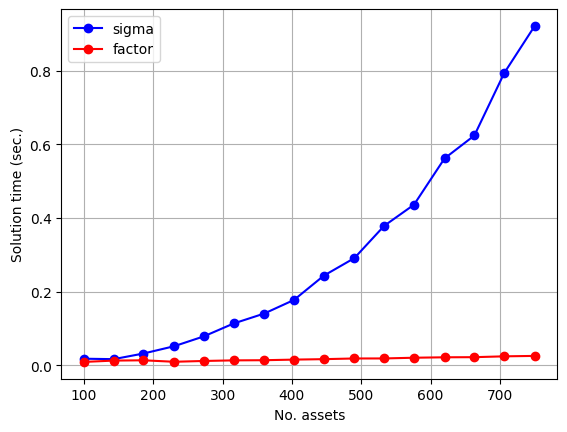

In [8]:
fix, ax = plt.subplots()
ax.plot(problem_dims, time_sigma, c="blue", marker="o", label="sigma")
ax.plot(problem_dims, time_factor, c="red", marker="o", label="factor")
ax.legend()
plt.xlabel("No. assets")
plt.ylabel("Solution time (sec.)")
plt.grid(True)

From the data, it is clear that the solve times of (2) are much smaller both in absolute and asymptotic terms.  The data may appear somewhat nonsmooth over the problem dimensions.  These are artifacts from multi-threading and different code paths in the computational kernels used for dense matrix multiplication.

## Takeaways

- Incorporating explicit factors to model risk in a gurobipy model is straightforward.
- Using factor risk models instead of the derived full covariance matrix can greatly improve solution time.

## References

[1] Menchero, J., Orr, D., Wang, J.: The Barra US equity model (USE4), methodology notes. English,
MSCI (May (2011)

[2] Gérard Cornuéjols, Javier Peña, and Reha Tütüncü. Optimization Methods in Finance. Cambridge University Press, 2 edition, 2018. doi:10.1017/9781107297340.